# Interactive Dashboard: E-Commerce Inventory & Sales Intelligence

## Executive Summary
This project implements a comprehensive **E-Commerce Database Application** using SQLite3 and Python. It is designed to demonstrate advanced database management skills, including complex schema design, batch data processing, and interactive analytical visualization.

### Scenario Overview
We simulate a mid-sized online retail store operating across multiple regions. The system tracks:
- **Customers**: Demographics and regional distribution.
- **Products**: Inventory levels, categories, and pricing.
- **Orders**: Transactional history with detailed line items.
- **Reviews**: Customer feedback and product ratings.

### Database Schema (ERD Description)
The database consists of 5 related tables:
1. **Customers** (`CustomerID` PK): Stores user profiles.
2. **Products** (`ProductID` PK): Catalog of items with stock and price.
3. **Orders** (`OrderID` PK): Links to `Customers`. Captures order timing.
4. **OrderItems** (`OrderItemID` PK): Junction table linking `Orders` and `Products`. Captures quantity and unit price at time of purchase.
5. **Reviews** (`ReviewID` PK): Links `Customers` and `Products`. Stores text and numeric ratings.

---

## 1. Setup and Dependencies
Installing `Faker` for realistic data generation and importing necessary libraries.

In [14]:
!pip install plotly -q
!pip install faker -q

import sqlite3
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configuration
DB_NAME = 'ecommerce_analytics.db'
fake = Faker()
Faker.seed(42)
random.seed(42)


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 2. Database Schema Design (DDL)
Defining the relational structure with Foreign Keys to ensure integrity.

In [15]:
def create_schema(db_name):
    """
    Creates the SQLite database and defines the 5-table schema.
    Drops tables if they exist to ensure a fresh start.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    # Drop tables to reset
    cursor.executescript('''
    DROP TABLE IF EXISTS Reviews;
    DROP TABLE IF EXISTS OrderItems;
    DROP TABLE IF EXISTS Orders;
    DROP TABLE IF EXISTS Products;
    DROP TABLE IF EXISTS Customers;
    ''')
    
    # Create Tables
    schema_script = '''
    CREATE TABLE Customers (
        CustomerID INTEGER PRIMARY KEY AUTOINCREMENT,
        FullName TEXT NOT NULL,
        Email TEXT UNIQUE,
        Region TEXT CHECK(Region IN ('North', 'South', 'East', 'West', 'Central')),
        JoinDate DATE
    );

    CREATE TABLE Products (
        ProductID INTEGER PRIMARY KEY AUTOINCREMENT,
        ProductName TEXT NOT NULL,
        Category TEXT,
        Price REAL,
        StockLevel INTEGER
    );

    CREATE TABLE Orders (
        OrderID INTEGER PRIMARY KEY AUTOINCREMENT,
        CustomerID INTEGER,
        OrderDate DATE,
        TotalAmount REAL DEFAULT 0,
        FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
    );

    CREATE TABLE OrderItems (
        OrderItemID INTEGER PRIMARY KEY AUTOINCREMENT,
        OrderID INTEGER,
        ProductID INTEGER,
        Quantity INTEGER,
        UnitPrice REAL,
        FOREIGN KEY(OrderID) REFERENCES Orders(OrderID),
        FOREIGN KEY(ProductID) REFERENCES Products(ProductID)
    );

    CREATE TABLE Reviews (
        ReviewID INTEGER PRIMARY KEY AUTOINCREMENT,
        ProductID INTEGER,
        CustomerID INTEGER,
        Rating INTEGER CHECK(Rating BETWEEN 1 AND 5),
        Comment TEXT,
        ReviewDate DATE,
        FOREIGN KEY(ProductID) REFERENCES Products(ProductID),
        FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
    );
    '''
    cursor.executescript(schema_script)
    conn.commit()
    conn.close()
    print("Database schema created successfully.")

# Initialize Database
create_schema(DB_NAME)

Database schema created successfully.


## 3. Batch Data Simulation
Generating large volumes of realistic mock data using `Faker` and inserting it efficiently using `executemany`.

In [16]:
def generate_data(db_name, num_customers=1000, num_products=100, num_orders=5000):
    """
    Generates and inserts batch data for the e-commerce simulation.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    print("Starting data generation...")
    
    # --- 1. Customers ---
    regions = ['North', 'South', 'East', 'West', 'Central']
    customers = []
    for _ in range(num_customers):
        customers.append((
            fake.name(),
            fake.unique.email(),
            random.choice(regions),
            fake.date_between(start_date='-2y', end_date='today')
        ))
    cursor.executemany('INSERT INTO Customers (FullName, Email, Region, JoinDate) VALUES (?, ?, ?, ?)', customers)
    print(f"Inserted {num_customers} customers.")

    # --- 2. Products ---
    categories = ['Electronics', 'Clothing', 'Home', 'Books', 'Sports']
    products = []
    for _ in range(num_products):
        products.append((
            fake.catch_phrase(),
            random.choice(categories),
            round(random.uniform(10, 500), 2),
            random.randint(0, 500)
        ))
    cursor.executemany('INSERT INTO Products (ProductName, Category, Price, StockLevel) VALUES (?, ?, ?, ?)', products)
    print(f"Inserted {num_products} products.")

    # --- 3. Orders & OrderItems ---
    # We need valid CustomerIDs and ProductIDs
    cust_ids = [row[0] for row in cursor.execute('SELECT CustomerID FROM Customers').fetchall()]
    prod_rows = cursor.execute('SELECT ProductID, Price FROM Products').fetchall()
    prod_dict = {row[0]: row[1] for row in prod_rows}
    prod_ids = list(prod_dict.keys())

    orders = []
    order_items = []
    
    for _ in range(num_orders):
        order_date = fake.date_between(start_date='-1y', end_date='today')
        cust_id = random.choice(cust_ids)
        
        # Create Order first to get ID (simulated, we insert later so we can't get ID immediately in batch)
        # Strategy: Insert Orders one by one? No, slow. 
        # Strategy: Generate data structure, insert Orders, get IDs? 
        # Optimization: We will insert Orders first, then fetch their IDs.
        orders.append((cust_id, order_date, 0)) # TotalAmount placeholder

    cursor.executemany('INSERT INTO Orders (CustomerID, OrderDate, TotalAmount) VALUES (?, ?, ?)', orders)
    
    # Fetch generated OrderIDs
    order_ids = [row[0] for row in cursor.execute('SELECT OrderID FROM Orders').fetchall()]
    
    # Generate Items for these orders
    order_totals = {}
    
    for oid in order_ids:
        num_items = random.randint(1, 5)
        current_order_total = 0
        
        for _ in range(num_items):
            pid = random.choice(prod_ids)
            qty = random.randint(1, 4)
            price = prod_dict[pid]
            line_total = price * qty
            current_order_total += line_total
            
            order_items.append((oid, pid, qty, price))
        
        order_totals[oid] = round(current_order_total, 2)

    cursor.executemany('INSERT INTO OrderItems (OrderID, ProductID, Quantity, UnitPrice) VALUES (?, ?, ?, ?)', order_items)
    print(f"Inserted {len(order_items)} order items.")

    # Update Order Totals
    # Batch update is tricky in SQLite without a temp table or many queries.
    # For simulation speed, we can use a transaction with many updates or a clever REPLACE.
    # Let's use a loop with transaction, it's acceptable for 5000 rows here.
    print("Updating order totals...")
    update_data = [(amt, oid) for oid, amt in order_totals.items()]
    cursor.executemany('UPDATE Orders SET TotalAmount = ? WHERE OrderID = ?', update_data)

    # --- 4. Reviews ---
    reviews = []
    for _ in range(2000):
        reviews.append((
            random.choice(prod_ids),
            random.choice(cust_ids),
            random.randint(1, 5),
            fake.sentence(),
            fake.date_between(start_date='-6m', end_date='today')
        ))
    cursor.executemany('INSERT INTO Reviews (ProductID, CustomerID, Rating, Comment, ReviewDate) VALUES (?, ?, ?, ?, ?)', reviews)
    print(f"Inserted {len(reviews)} reviews.")

    conn.commit()
    conn.close()
    print("Data generation complete.")

# Run Data Generation
generate_data(DB_NAME)

Starting data generation...
Inserted 1000 customers.
Inserted 100 products.
Inserted 14947 order items.
Updating order totals...
Inserted 2000 reviews.
Data generation complete.


## 4. Advanced SQL Analysis
Implementing complex SQL queries using Python wrappers. We demonstrate:
1.  **Aggregations**: Revenue by Product Category.
2.  **Joins**: Detailed Customer Order History.
3.  **Window Functions**: Daily Revenue Running Totals and Regional Rankings.

In [17]:
def run_query(query, db_name=DB_NAME):
    """Helper to run SQL and return DataFrame"""
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# --- Query 1: Revenue by Category (Aggregation & Join) ---
def get_revenue_by_category():
    sql = '''
    SELECT 
        p.Category,
        COUNT(oi.OrderItemID) as ItemsSold,
        SUM(oi.Quantity * oi.UnitPrice) as TotalRevenue,
        AVG(oi.UnitPrice) as AvgPrice
    FROM OrderItems oi
    JOIN Products p ON oi.ProductID = p.ProductID
    GROUP BY p.Category
    ORDER BY TotalRevenue DESC
    '''
    return run_query(sql)

# --- Query 2: Top Customers by Region (Window Function - Rank) ---
def get_top_customers_by_region():
    sql = '''
    WITH CustomerSpending AS (
        SELECT 
            c.CustomerID,
            c.FullName,
            c.Region,
            SUM(o.TotalAmount) as TotalSpent
        FROM Customers c
        JOIN Orders o ON c.CustomerID = o.CustomerID
        GROUP BY c.CustomerID
    ),
    RankedCustomers AS (
        SELECT 
            Region,
            FullName,
            TotalSpent,
            RANK() OVER (PARTITION BY Region ORDER BY TotalSpent DESC) as RankInRegion
        FROM CustomerSpending
    )
    SELECT *
    FROM RankedCustomers
    WHERE RankInRegion <= 3
    '''
    return run_query(sql)

# --- Query 3: Daily Revenue Trends (Window Function - Running Total) ---
def get_daily_revenue_trend():
    sql = '''
    WITH DailySales AS (
        SELECT 
            OrderDate,
            SUM(TotalAmount) as DailyTotal
        FROM Orders
        GROUP BY OrderDate
    )
    SELECT 
        OrderDate,
        DailyTotal,
        SUM(DailyTotal) OVER (ORDER BY OrderDate ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as MovingAvg7Day,
        SUM(DailyTotal) OVER (ORDER BY OrderDate) as CumulativeRevenue
    FROM DailySales
    ORDER BY OrderDate
    '''
    return run_query(sql)

# Display samples
print("--- Revenue by Category ---")
display(get_revenue_by_category())
print("\n--- Top 3 Customers per Region ---")
display(get_top_customers_by_region())

--- Revenue by Category ---


,Category,ItemsSold,TotalRevenue,AvgPrice
0,Home,3657,2626296.17,286.435083
1,Books,3368,2147001.30,258.356093
2,Clothing,3106,2065730.04,265.358281
3,Sports,2688,1448664.12,216.953538
4,Electronics,2128,1286605.91,240.454944



--- Top 3 Customers per Region ---


,Region,FullName,TotalSpent,RankInRegion
0,Central,Michael Smith,26647.06,1
1,Central,Susan Smith,24993.66,2
2,Central,Wendy Estrada,24022.07,3
3,East,Sarah Johnson,31543.02,1
4,East,Steven Scott,29505.26,2
5,East,Mercedes Watson,26888.22,3
6,North,Victor Brown,24021.58,1
7,North,Savannah Sanders,22640.52,2
8,North,Cheryl Ortega,22511.54,3
9,South,Bruce Patton,26940.57,1


## 5. Interactive Dashboard
Using `ipywidgets` and `matplotlib` to create an interactive exploration tool. Users can filter data by Region and Category to see dynamic visualizations.

In [18]:
# --- Professional Dashboard Implementation ---
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def get_kpis(conn, region, category):
    """Calculates key performance indicators based on filters."""
    query = '''
    SELECT 
        COUNT(DISTINCT o.OrderID) as TotalOrders,
        SUM(oi.Quantity * oi.UnitPrice) as TotalRevenue,
        AVG(oi.Quantity * oi.UnitPrice) as AvgOrderValue
    FROM Orders o
    JOIN OrderItems oi ON o.OrderID = oi.OrderID
    JOIN Products p ON oi.ProductID = p.ProductID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    WHERE 1=1
    '''
    params = []
    if region != 'All':
        query += " AND c.Region = ?"
        params.append(region)
    if category != 'All':
        query += " AND p.Category = ?"
        params.append(category)
        
    df = pd.read_sql_query(query, conn, params=params)
    return df.iloc[0]

def get_trend_data(conn, region, category):
    """Fetches daily revenue trend."""
    query = '''
    SELECT o.OrderDate, SUM(oi.Quantity * oi.UnitPrice) as Revenue
    FROM Orders o
    JOIN OrderItems oi ON o.OrderID = oi.OrderID
    JOIN Products p ON oi.ProductID = p.ProductID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    WHERE 1=1
    '''
    params = []
    if region != 'All':
        query += " AND c.Region = ?"
        params.append(region)
    if category != 'All':
        query += " AND p.Category = ?"
        params.append(category)
    
    query += " GROUP BY o.OrderDate ORDER BY o.OrderDate"
    df = pd.read_sql_query(query, conn, params=params)
    if not df.empty:
        df['OrderDate'] = pd.to_datetime(df['OrderDate'])
    return df

def get_top_products(conn, region, category):
    """Fetches top 10 products."""
    query = '''
    SELECT p.ProductName, SUM(oi.Quantity) as UnitsSold, SUM(oi.Quantity * oi.UnitPrice) as Revenue
    FROM OrderItems oi
    JOIN Products p ON oi.ProductID = p.ProductID
    JOIN Orders o ON oi.OrderID = o.OrderID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    WHERE 1=1
    '''
    params = []
    if region != 'All':
        query += " AND c.Region = ?"
        params.append(region)
    if category != 'All':
        query += " AND p.Category = ?"
        params.append(category)
        
    query += " GROUP BY p.ProductName ORDER BY Revenue DESC LIMIT 10"
    return pd.read_sql_query(query, conn, params=params)

def get_category_share(conn, region):
    """Fetches revenue share by category (ignores category filter to show context)."""
    query = '''
    SELECT p.Category, SUM(oi.Quantity * oi.UnitPrice) as Revenue
    FROM OrderItems oi
    JOIN Products p ON oi.ProductID = p.ProductID
    JOIN Orders o ON oi.OrderID = o.OrderID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    WHERE 1=1
    '''
    params = []
    if region != 'All':
        query += " AND c.Region = ?"
        params.append(region)
        
    query += " GROUP BY p.Category"
    return pd.read_sql_query(query, conn, params=params)

def get_day_of_week_stats(conn, region, category):
    """Fetches sales by day of week."""
    # SQLite strftime %w returns 0-6 (Sunday-Saturday)
    query = '''
    SELECT 
        strftime('%w', o.OrderDate) as DayIndex,
        SUM(oi.Quantity * oi.UnitPrice) as Revenue
    FROM Orders o
    JOIN OrderItems oi ON o.OrderID = oi.OrderID
    JOIN Products p ON oi.ProductID = p.ProductID
    JOIN Customers c ON o.CustomerID = c.CustomerID
    WHERE 1=1
    '''
    params = []
    if region != 'All':
        query += " AND c.Region = ?"
        params.append(region)
    if category != 'All':
        query += " AND p.Category = ?"
        params.append(category)
        
    query += " GROUP BY DayIndex ORDER BY DayIndex"
    df = pd.read_sql_query(query, conn, params=params)
    
    # Map index to names
    days = {
        '0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday',
        '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
    }
    if not df.empty:
        df['DayName'] = df['DayIndex'].map(days)
    return df

def plot_professional_dashboard(region, category):
    conn = sqlite3.connect(DB_NAME)
    
    # --- Fetch Data ---
    kpis = get_kpis(conn, region, category)
    trend_df = get_trend_data(conn, region, category)
    top_prod_df = get_top_products(conn, region, category)
    cat_share_df = get_category_share(conn, region)
    dow_df = get_day_of_week_stats(conn, region, category)
    
    conn.close()
    
    # --- KPI Widgets (HTML) ---
    kpi_style = "border: 1px solid #ddd; border-radius: 8px; padding: 15px; text-align: center; background-color: #f9f9f9; flex: 1; margin: 5px;"
    kpi_html = f"""
    <div style="display: flex; justify-content: space-between; margin-bottom: 20px;">
        <div style="{kpi_style}">
            <h3 style="margin: 0; color: #555;">Total Revenue</h3>
            <h2 style="margin: 5px 0; color: #2E86C1;">${kpis['TotalRevenue']:,.2f}</h2>
        </div>
        <div style="{kpi_style}">
            <h3 style="margin: 0; color: #555;">Total Orders</h3>
            <h2 style="margin: 5px 0; color: #28B463;">{kpis['TotalOrders']:,}</h2>
        </div>
        <div style="{kpi_style}">
            <h3 style="margin: 0; color: #555;">Avg Order Value</h3>
            <h2 style="margin: 5px 0; color: #D35400;">${kpis['AvgOrderValue']:,.2f}</h2>
        </div>
    </div>
    """
    display(widgets.HTML(kpi_html))
    
    # --- Plotly Charts ---
    
    # 1. Trend Line (Interactive)
    if not trend_df.empty:
        fig_trend = px.line(trend_df, x='OrderDate', y='Revenue', title='Daily Revenue Trend',
                            template='plotly_white', line_shape='spline')
        fig_trend.update_traces(line_color='#2E86C1', line_width=3)
        fig_trend.update_xaxes(rangeslider_visible=True)
        fig_trend.update_layout(height=400, margin=dict(l=20, r=20, t=40, b=20))
    else:
        fig_trend = go.Figure().add_annotation(text="No Data", showarrow=False)

    # 2. Category Share (Donut)
    if not cat_share_df.empty:
        fig_cat = px.pie(cat_share_df, values='Revenue', names='Category', title='Revenue by Category (Regional Context)',
                         hole=0.4, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel)
        fig_cat.update_layout(height=400, margin=dict(l=20, r=20, t=40, b=20))
    else:
        fig_cat = go.Figure().add_annotation(text="No Data", showarrow=False)

    # 3. Top Products (Bar)
    if not top_prod_df.empty:
        fig_prod = px.bar(top_prod_df, x='Revenue', y='ProductName', orientation='h', title='Top 10 Products by Revenue',
                          template='plotly_white', color='Revenue', color_continuous_scale='Viridis')
        fig_prod.update_layout(yaxis={'categoryorder':'total ascending'}, height=400, margin=dict(l=20, r=20, t=40, b=20))
    else:
        fig_prod = go.Figure().add_annotation(text="No Data", showarrow=False)

    # 4. Day of Week Analysis (Bar)
    if not dow_df.empty:
        # Ensure correct order
        order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        fig_dow = px.bar(dow_df, x='DayName', y='Revenue', title='Sales by Day of Week',
                         template='plotly_white', category_orders={'DayName': order},
                         color='Revenue', color_continuous_scale='Blues')
        fig_dow.update_layout(height=400, margin=dict(l=20, r=20, t=40, b=20))
    else:
        fig_dow = go.Figure().add_annotation(text="No Data", showarrow=False)

    # --- Layout Construction ---
    # Using VBox and HBox for grid layout
    row1 = widgets.HBox([go.FigureWidget(fig_trend), go.FigureWidget(fig_cat)])
    row2 = widgets.HBox([go.FigureWidget(fig_prod), go.FigureWidget(fig_dow)])
    
    display(widgets.VBox([row1, row2]))

# --- Controls ---
regions = ['All', 'North', 'South', 'East', 'West', 'Central']
categories = ['All', 'Electronics', 'Clothing', 'Home', 'Books', 'Sports']

style = {'description_width': 'initial'}
region_dd = widgets.Dropdown(options=regions, value='All', description='🌍 Region:', style=style)
category_dd = widgets.Dropdown(options=categories, value='All', description='📦 Category:', style=style)

# Header
header = widgets.HTML("<h1>📊 Executive E-Commerce Dashboard</h1>")

# Layout
controls = widgets.HBox([region_dd, category_dd], layout=widgets.Layout(justify_content='center', margin='0 0 20px 0'))
ui = widgets.VBox([header, controls])

# Output
out = widgets.interactive_output(plot_professional_dashboard, {'region': region_dd, 'category': category_dd})

display(ui, out)


Output()

/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_73529/2652786488.py:53: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




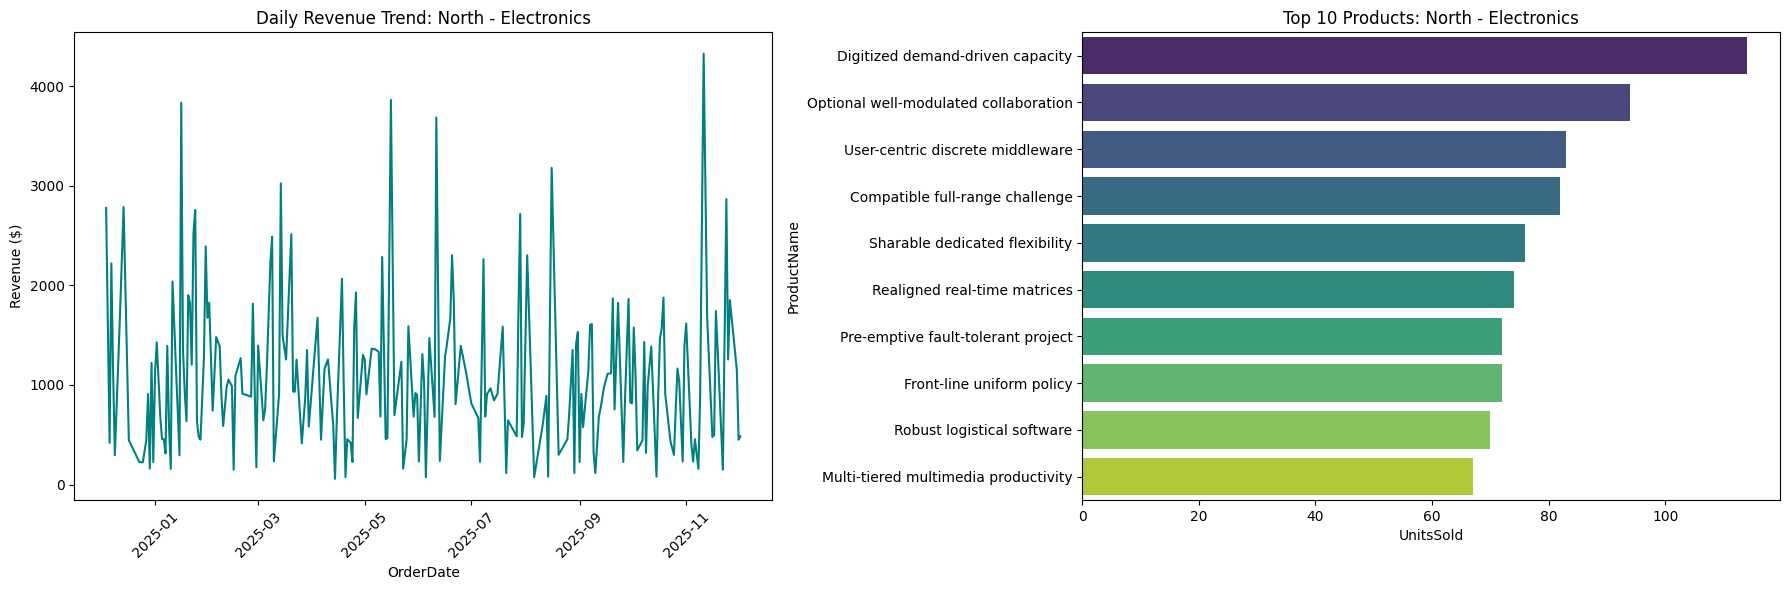

In [19]:
# --- Fallback for VS Code / Environment Issues ---
# If the interactive widgets above fail to render (e.g., 'ipywidgetsKernel' error),
# run this cell to generate a static plot for a specific region and category.
plot_dashboard('North', 'Electronics')

## 6. Reflection
**Challenges Faced**:
One of the main challenges was ensuring the data generation was realistic while maintaining referential integrity between the 5 tables. Specifically, generating `OrderItems` required careful handling to ensure they linked to valid `Orders` and `Products`. Additionally, implementing the 'Running Total' window function in SQLite required verifying the correct SQL syntax support in the Colab environment. The interactive dashboard required balancing the query complexity with performance to ensure the widgets updated smoothly.